## Setup

Please execute the cell(s) below to initialize the notebook environment.

In [1]:
# @title Install dependencies
!pip install poetry

In [2]:
# @title Install SMorph Python module
!pip install https://github.com/swanandlab/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [3]:
# Imports
on_colab = 'google.colab' in str(get_ipython())

import warnings
warnings.filterwarnings('ignore')

if not on_colab:
    import napari
import smorph.util.autocrop as ac
import ipywidgets as widgets

In [4]:
# Helper function
def view_3D(*args):
    """Views a 3D image."""
    n_images = len(args)
    if not on_colab and n_images > 0:  
        with napari.gui_qt():
            viewer = napari.view_image(**args[0], ndisplay=3)
            for itr in range(1, n_images):
                if args[itr]['data'].max() > 1:
                    del args[itr]['colormap']
                    del args[itr]['gamma']
                    viewer.add_labels(**args[itr])
                else:
                    viewer.add_image(**args[itr])

---

## Step 1: Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.
- Followed by non-local means denoising using auto-calibrated parameters

{'h': 0.026935523072649407, 'patch_size': 4, 'patch_distance': 2}


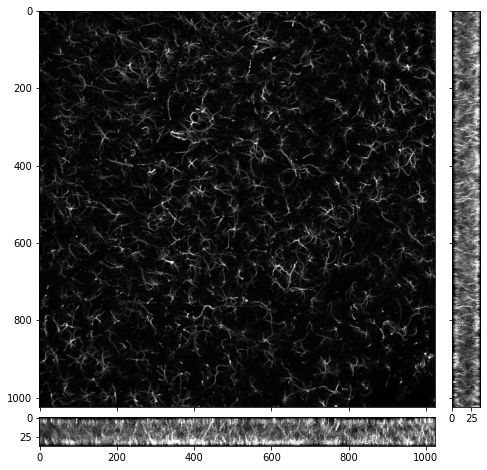

In [5]:
CONFOCAL_TISSUE_IMAGE = 'E:/Garima Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_21 DAYS/allImg/CA3/DMI_SC110.1M_3_UNMARKED__20X_SEC 2_LEFT CA3_21 DAY.czi'  #@param

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)

denoiser = ac.calibrate_nlm_denoiser(original)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
print(denoise_parameters)
denoised = ac.denoise(original, denoise_parameters)
ac.projectXYZ(denoised, .5, .5, 1)

In [6]:
denoised = ac.deconvolve(denoised, CONFOCAL_TISSUE_IMAGE)

In [7]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'})

---

## Step 2: Select ROI using Polygonal Lasso Tool

Set two variables:
- `SELECT_ROI`: True, If you want to select ROI manually; else False
- `NAME_ROI`: Name of the manually selected ROI
- `FILE_ROI`: Path to the ROI file; else None

In [8]:
SELECT_ROI = True
NAME_ROI = ''
FILE_ROI = 'E:/Garima Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_21 DAYS/allRoi/CA3/DMI_MSP2.1MA_3_LONG MARK_20X_SEC 1_RIGHT CA3_21 DAY.roi'
linebuilder = None
import matplotlib.pyplot as plt
%matplotlib widget

IMG_NAME = CONFOCAL_TISSUE_IMAGE.split('/')[-1].split('.')[0]

import matplotlib.pyplot as plt
file_roi_widget = widgets.Text(value=FILE_ROI, description='file_roi')
def roi_interact(select_roi=SELECT_ROI,
                 name_roi=NAME_ROI, draw_roi=False, file_roi=FILE_ROI):
  global SELECT_ROI, NAME_ROI, FILE_ROI, linebuilder, file_roi_widget
  SELECT_ROI, NAME_ROI, FILE_ROI = select_roi, name_roi, file_roi
  NAME_ROI = NAME_ROI if SELECT_ROI else ''
  if draw_roi:
    FILE_ROI = None
    file_roi_widget.layout.visibility = 'hidden'
  else:
    file_roi_widget.value = FILE_ROI
    file_roi_widget.layout.visibility = 'visible'
    plt.clf()
  linebuilder = None if not SELECT_ROI else ac.select_ROI(denoised, IMG_NAME + '-' + NAME_ROI, FILE_ROI)


_ = widgets.interact(roi_interact, select_roi=SELECT_ROI,
                     name_roi=NAME_ROI, draw_roi=False, file_roi=file_roi_widget)

interactive(children=(Checkbox(value=True, description='select_roi'), Text(value='', description='name_roi'), …

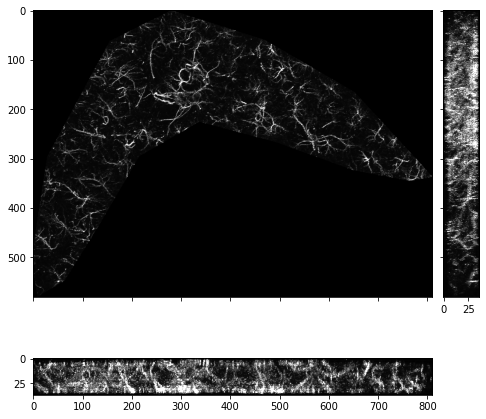

In [9]:
%matplotlib inline
if SELECT_ROI:
    original, denoised = ac.mask_ROI(original, denoised, linebuilder)
    ac.projectXYZ(denoised, .5, .5, 1)

---

## Step 3: Segmentation

### 3.1 Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

Understand their effect by configuring three parameters:
- `LOW_DELTA`: Pixel intensity value corresponding to change in `LOW_THRESH`
- `HIGH_DELTA`: Pixel intensity value corresponding to change in `HIGH_THRESH`
- `N_STEPS`: Number of steps of delta in threshold to take in both directions

In [10]:
import skimage
otsu_value = skimage.filters.threshold_otsu(denoised)
LOW_THRESH = otsu_value
HIGH_THRESH = otsu_value

LOW_DELTA = .0025
HIGH_DELTA = .00
N_STEPS = 1
results = None
%matplotlib inline
def test_thresholds(low_thresh, high_thresh, low_delta, high_delta, n_steps):
  global results, LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS
  LOW_THRESH, HIGH_THRESH, N_STEPS = low_thresh, high_thresh, n_steps
  LOW_DELTA, HIGH_DELTA = low_delta, high_delta
  results = ac.testThresholds(denoised, LOW_THRESH, HIGH_THRESH, LOW_DELTA,
                              HIGH_DELTA, N_STEPS, 'gist_earth')

_ = widgets.interact(test_thresholds,
                     low_thresh=widgets.FloatSlider(LOW_THRESH, min=0, max=1, step=.01,
                                                    readout_format='.4f', layout=widgets.Layout(width='100%')),
                     high_thresh=widgets.FloatSlider(HIGH_THRESH, min=0, max=1, step=.01,
                                                     readout_format='.4f', layout=widgets.Layout(width='100%')),
                     low_delta=widgets.FloatSlider(LOW_DELTA, min=0, max=1, step=.0005,
                                                   readout_format='.4f', layout=widgets.Layout(width='100%')),
                     high_delta=widgets.FloatSlider(HIGH_DELTA, min=0, max=1, step=.0005,
                                                    readout_format='.4f', layout=widgets.Layout(width='100%')),
                     n_steps=widgets.IntSlider(N_STEPS, min=0, max=10,
                                               layout=widgets.Layout(width='100%'))
)

interactive(children=(FloatSlider(value=0.193359375, description='low_thresh', layout=Layout(width='100%'), ma…

In [11]:
view_3D({'data': denoised, 'colormap': 'inferno', 'name': 'denoised'}, *results)

### Thresholding results

In [12]:
thresholded = ac.threshold(denoised, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)

In [13]:
prefiltering_volume = thresholded.sum()
f'Prefiltering Volume: {prefiltering_volume}'

'Prefiltering Volume: 40953'

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

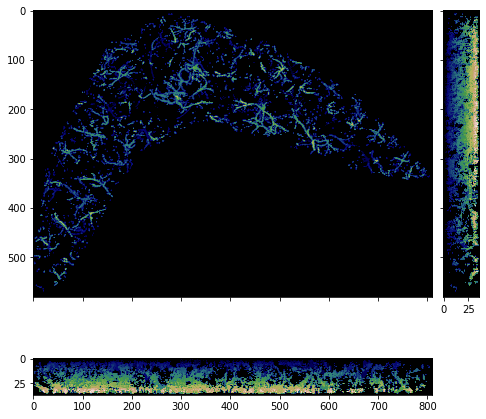

In [14]:
# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = ac.filter_labels(labels, thresholded, linebuilder)
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [15]:
view_3D({'data': filtered_labels, 'colormap': 'gray', 'gamma': .8, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'gamma': .8, 'name': 'labels'})

In [16]:
postfiltering_volume = (filtered_labels > 0).sum()
f'Postfiltering Volume: {postfiltering_volume}; ' \
f'%age loss in volume: {(prefiltering_volume - postfiltering_volume) / prefiltering_volume * 100} %'

'Postfiltering Volume: 37213; %age loss in volume: 9.1324200913242 %'

In [17]:
# get the centroids and label values from the label image
regions = ac.arrange_regions(filtered_labels)
centroid_coords = [r.centroid for r in regions]

# store the labels for each blob in a properties dictionary
pts_properties = {'obj': [i for i in range(len(regions))]}

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check segmented cells on whole image

In [18]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(denoised, name='denoised', ndisplay=3)
        viewer.add_labels(filtered_labels, name='filtered_labels')
        viewer.add_points(centroid_coords, edge_color='transparent',
                          face_color='transparent',
                          properties=pts_properties, text='obj')

#### 3.3.2: Check batches of objects

In [19]:
N_BATCHES = ac.paginate_objs(regions, pg_size=50)

189 objects detected.
There will be 4 batches, set `BATCH_NO` from 0 to 3 inclusive


In [20]:
# Set `BATCH_NO` to view detected objects in paginated 2D MIP views.
def plot_batch(BATCH_NO):
  ac.project_batch(BATCH_NO, N_BATCHES, regions, denoised)

_ = widgets.interact(plot_batch, BATCH_NO=widgets.IntSlider(min=0,
                       max=N_BATCHES-1, layout=widgets.Layout(width='100%')))

interactive(children=(IntSlider(value=0, description='BATCH_NO', layout=Layout(width='100%'), max=3), Output()…

#### 3.3.2: Check individual objects
Select individual objects using `OBJ_INDEX`.

In [21]:
OBJ_INDEX = 0
extracted_cell = None
minz, miny, minx, maxz, maxy, maxx = 0, 0, 0, 0, 0, 0

def plot_single(obj_index):
  global OBJ_INDEX, extracted_cell, minz, miny, minx, maxz, maxy, maxx
  OBJ_INDEX = obj_index
  extracted_cell = ac.extract_obj(regions[OBJ_INDEX], denoised)
  minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox
  ac.projectXYZ(extracted_cell, .5, .5, 1)

_ = widgets.interact(plot_single, obj_index=widgets.IntSlider(min=0,
                       max=len(regions)-1, layout=widgets.Layout(width='100%')))

interactive(children=(IntSlider(value=0, description='obj_index', layout=Layout(width='100%'), max=188), Outpu…

In [22]:
view_3D({'data': denoised[minz:maxz, miny:maxy, minx:maxx], 'name': 'denoised'},
        {'data': regions[OBJ_INDEX].image, 'colormap': 'yellow', 'name': 'thresholded'},
        {'data': extracted_cell, 'colormap': 'inferno', 'name': 'extracted_cell'})

---

## Step 4: Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = '3d' for 3D cells, or
- Set `OUTPUT_OPTION` = 'mip' for Max Intensity Projections.

In [25]:
LOW_VOLUME_CUTOFF = 1101  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 3133  # filter cell clusters
OUTPUT_OPTION = 'mip'  # '3d' for 3D cells, 'mip' for Max Intensity Projections
SEGMENT_TYPE = 'segmented'
reconstructed_cells = None

import numpy as np

def volume_range(low_volume_cutoff=LOW_VOLUME_CUTOFF,
                 high_volume_cutoff=HIGH_VOLUME_CUTOFF, output_option=OUTPUT_OPTION,
                 segment_type=SEGMENT_TYPE):
  global LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, SEGMENT_TYPE, reconstructed_cells
  LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF = low_volume_cutoff, high_volume_cutoff
  OUTPUT_OPTION, SEGMENT_TYPE = output_option, segment_type

  reconstructed_cells = np.zeros_like(denoised)
  for region in regions:
    if LOW_VOLUME_CUTOFF <= region.area <= HIGH_VOLUME_CUTOFF:
      minz, miny, minx, maxz, maxy, maxx = region.bbox
      reconstructed_cells[minz:maxz, miny:maxy, minx:maxx] += region.filled_image * denoised[minz:maxz, miny:maxy, minx:maxx]
  ac.projectXYZ(reconstructed_cells, .5, .5, 1, 'gist_heat')

_ = widgets.interact(volume_range, low_volume_cutoff=widgets.IntSlider(value=LOW_VOLUME_CUTOFF,
                         min=0, max=regions[-1].area, layout=widgets.Layout(width='100%')),
                     high_volume_cutoff=widgets.IntSlider(value=HIGH_VOLUME_CUTOFF,
                         min=0, max=regions[-1].area, layout=widgets.Layout(width='100%')),
                     output_option=['3d', 'mip', 'both'],
                     segment_type=['segmented', 'unsegmented', 'both'])

interactive(children=(IntSlider(value=1101, description='low_volume_cutoff', layout=Layout(width='100%'), max=…

In [24]:
view_3D({'data': reconstructed_cells, 'name': 'output'})

In [ ]:
ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF,
                HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised,
                regions, None, SEGMENT_TYPE, NAME_ROI, linebuilder)